In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from google.colab import drive

In [ ]:
drive.mount("/content/drive/")

# DenseNet201

In [ ]:
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return None
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalización
    return img

Como mencioné en el archivo *'convert_dicom.py'*, el preprocesado de las imágenes se lleva a cabo en local. Una vez convertidas se suben a drive y de ahi las lee este notebook

In [ ]:
# Paso 1: Cargar y preprocesar datos
train_df = pd.read_csv("/content/drive/MyDrive/xRayClassification/train.csv", header=0)
test_df = pd.read_csv("/content/drive/MyDrive/xRayClassification/sample_submission.csv", header=0)

# Construir las rutas completas de las imágenes de entrenamiento y prueba
train_df['image_path'] = '/content/drive/MyDrive/xRayClassification/V4/train/' + train_df['SOPInstanceUID'].astype(str) + '.png'
test_df['image_path'] = '/content/drive/MyDrive/xRayClassification/V4/test/' + test_df['SOPInstanceUID'].astype(str) + '.png'

In [ ]:
# Paso 2: Dividir datos en conjuntos de entrenamiento y validación
train_images = [preprocess_image(image_path, (256, 256)) for image_path in train_df['image_path']]
train_labels = train_df['Target']

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
# Paso 3: Crear generadores de datos para aumentar el conjunto de entrenamiento
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=False)
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=16)

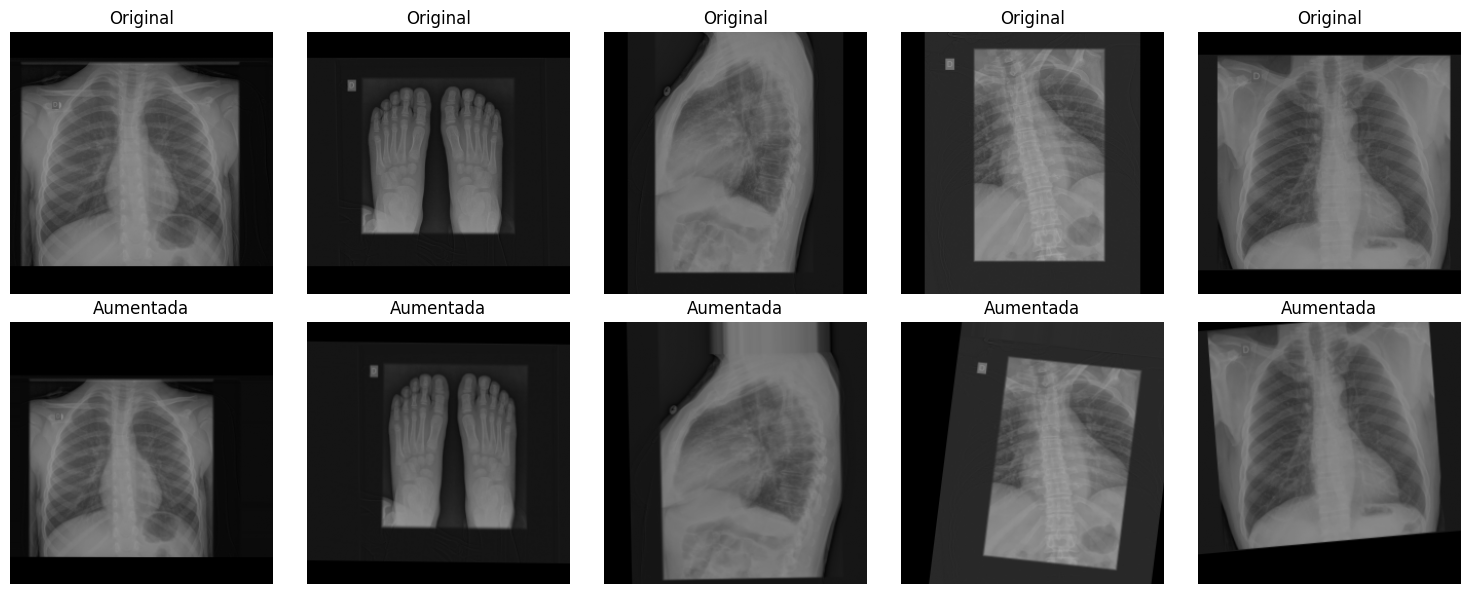

In [ ]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes originales
original_images = X_train[:5]

# Obtener un lote de imágenes aumentadas
augmented_images = [train_datagen.random_transform(image) for image in original_images]

# Mostrar las imágenes originales junto con las aumentadas
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images[i])
    plt.title("Aumentada")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet201
# Modelo
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las primeras capas del modelo base y permitir el ajuste de las últimas
for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

# Añadir capas adicionales al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(22, activation='softmax')(x)  # Ajusta según el número de clases

# Compilar el modelo
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0007), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Definir el callback de ModelCheckpoint
checkpoint = ModelCheckpoint('mejor_modelo.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
  # Entrenar el modelo con el callback
history = model.fit(train_generator, epochs=15, validation_data=(np.array(X_val), y_val), callbacks=[checkpoint])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.5932 - loss: 1.5986
Epoch 1: val_accuracy improved from -inf to 0.88281, saving model to mejor_modelo.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.5952 - loss: 1.5900 - val_accuracy: 0.8828 - val_loss: 0.5321
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8611 - loss: 0.4570
Epoch 2: val_accuracy improved from 0.88281 to 0.91016, saving model to mejor_modelo.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - accuracy: 0.8611 - loss: 0.4566 - val_accuracy: 0.9102 - val_loss: 0.2618
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9232 - loss: 0.2416
Epoch 3: val_accuracy improved from 0.91016 to 0.91406, saving model to mejor_modelo.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 340ms/step - accuracy: 0.9231 - loss: 0.2424 - val_accuracy: 0.9141 - val_loss: 0.3617
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9550 - loss: 0.1462
Epoch 4: val_accuracy improved from 0.91406 t

### mejor_modelo.keras = xrayclassifier.keras
| Conjunto       | Accuracy | Loss   |
|----------------|----------|--------|
| Entrenamiento  | 0.9777   | 0.0669 |
| Validación     | 0.9727   | 0.1454 |

*epoch 12.